# Práctica 1 - Self-Organising Maps - COLORES
## Preparación de entorno
#### Importar librerías de código

Álvaro Chavarri, Daniel Ojeda, Carlos Vega y Lucía Gálvez

In [1]:
# from __future__ import division

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches

%matplotlib inline

#### Dataset que se va a utilizar para el entrenamiento

In [2]:
# Código para obtener el Dataset que se va a usar en el entrenamiento
valor_min = 0
valor_max = 255
valores_color = 3
num_colores = 100
# creamos la matriz por separado
datos = np.random.randint(valor_min, valor_max, (num_colores, valores_color))

## SOM Setup
#### Variables definidas por el alumno

In [3]:
# Inicializa tamaño del mapa de Kohonen, número de iteraciones y learning rate
# Inicializa normalizar_datos dependiendo de si tienes que normalizar los datos o no
lado_mapa = 20
periodo = 10000
learning_rate = 0.02 
normalizar_datos = 'true'

#### A partir de este punto solo hay cálculos. No se introducen más valores "a mano"

In [4]:
# Establece el numero de entradas del mapa y el número de datos que se van a usar para entrenar. 
# Utiliza una función que obtenga automáticamente los valores a partir del Dataset.
num_entradas = len(datos)
num_datos = len(datos[0])

# Calcula el vecindario inicial. Debe ser la mitad del lado del mapa de Kohonen
vecindario_inicial = lado_mapa/2

# Normaliza los datos si fuese necesario dividiendo cada dato por el máximo en la matriz
if normalizar_datos == 'true':
    datosN = (datos-np.min(datos))/(np.max(datos)-(np.min(datos)))
    
# Crea una matriz de pesos con valores random entre 0 y 1. Usa la función random.random de la librería NumPy
m_pesos = np.random.random((lado_mapa, lado_mapa, valores_color))

#### Funciones para entrenar/clasificar

##### Calcular BMU
Esta función encuentra la neurona ganadora, calculando la distancia Euclídea neurona-patrón y guardando las coordenadas en la BMU (bmu_idx) 

In [5]:
# Función para encontrar la BMU
"""
   Encuentra la BMU para un patrón de entrada.
   Entradas: (patrón_de_entrada, matriz_de_pesos, número_de_entradas)
   Salidas:  (bmu, bmu_idx) tupla donde
               bmu: vector de pesos de la neurona ganadora
               bum_idx: coordenadas de la neurona ganadora
"""
def calcular_bmu(patron_entrada, m_pesos, num_entradas):
    #inicializamos la distancia minina
    dMin = np.iinfo(np.int).max
    #recorremos la matriz de pesos
    for x in range (m_pesos.shape[0]): #para x
        for y in range (m_pesos.shape[1]): #para y
            w = m_pesos[x, y] #vector de pesos
            dEuclidea = np.sqrt(np.sum((w - patron_entrada)** 2)) #distancia Euclidea
            if dEuclidea < dMin:
                dMin = dEuclidea
                bmu_idx = np.array([x, y])
    #vector de pesos de la neurona ganadora
    bmu = m_pesos[bmu_idx[0], bmu_idx[1]]
    return (bmu, bmu_idx)


##### Variación learning rate
Esta función calcula eta para la i-ésima iteración

In [6]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta)
"""
   Calcula el Learning Rate (eta) que corresponde a la i-ésima presentación.
   Entradas: (learning_rate_inicial, iteracion, período)
   Salidas:  learning_rate para la iteración i

"""
def variacion_learning_rate(learning_rate, i, periodo):
    learning_rateV = learning_rate * (1-(i/periodo))
    return learning_rateV

##### Variación vecindario
Esta función calcula el desdenso del vecindario

In [7]:
# Función para calcular el descenso del vecindario (v)
"""
   Calcula el vecindario  (v) que corresponde a la i-ésima presentación.
   Entradas: (vecindario_inicial, iteracion, período)
   Salidas:  lvecindario para la iteración i

"""
def variacion_vecindario(vecindario_inicial, i, periodo):
    lvecindario = 1 + vecindario_inicial * (1-(i/periodo))
    return lvecindario

##### Decay
Esta función calcula eta en función de la distancia a la BMU

In [8]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta) en función de la distancia a la BMU
"""
   Calcula la amortiguación de eta en función de la distancia en el mapa entre una neurona y la BMU.
   Entradas: (distancia_BMU, vecindario_actual)
   Salidas:  amortiguación para la iteración

"""
def decay(distancia_BMU, vecindario_actual):
    return np.exp(-distancia_BMU**2 / (2*vecindario_actual**2))

#### Funciones para dibujar la salida de la red

Esta función nos permite pintar la matriz de los valores con los colores RGB

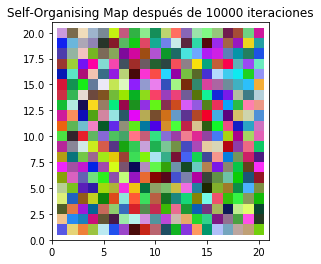

In [9]:
# Función para pintar una matriz de valores como colores RGB
def pintar_mapa(matriz_valores):
    fig = plt.figure()
    
    # Establece ejes
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, m_pesos.shape[0]+1))
    ax.set_ylim((0, m_pesos.shape[1]+1))
    ax.set_title('Self-Organising Map después de %d iteraciones' % periodo)

    # Dibuja los rectángulos de color RGB
    for x in range(1, matriz_valores.shape[0] + 1):
        for y in range(1, matriz_valores.shape[1] + 1):
            ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                         facecolor=matriz_valores[x-1,y-1,:],
                         edgecolor='none'))
    plt.show()
    
pintar_mapa(m_pesos)

## SOM Entrenamiento

#### Creación del bucle para entrenar la red

In [37]:
# Entrena la red con el dataset de entrenamiento
for i in range(periodo):
    if i % 100 == 0: #cada 100 iteraciones imprimimos el número correspondiente
        print('Iteración: ', i)
    #patrón de entrada escogido al azar y convertido al formato de m_pesos
    patron_entrada = datosN[np.random.randint(datos.shape[0])] 
    #buscamos la BMU
    bmu, bmu_idx = calcular_bmu(patron_entrada, m_pesos, num_entradas)
    #calculamos eta y el vecindario correspondientes a la iteración i
    eta = variacion_learning_rate(learning_rate, i, periodo)
    v = variacion_vecindario(vecindario_inicial, i, periodo)

    #actualizamos el vector de pesos y así nos acercamos al patrón
    for x in range(lado_mapa):
        for y in range(lado_mapa):
            w = m_pesos[x, y] #actualizamos el vector de pesos
            #calculamos la distancia euclídea para cada neurona y acercarnos a la correspondiente
            distEuclidea = np.sqrt(np.sum((np.array([x,y]) - bmu_idx)**2))
            if distEuclidea <= vecindario_inicial: #si la distancia euclidea es menor o igual que el vecindario
                #calculamos la amortigüación 
                amortiguacion = decay(distEuclidea, v)
                #actualizamos el vector de pesos de la neurona
                m_pesos[x, y] = w + eta * amortiguacion * (patron_entrada - w)

m_pesos

Iteración:  0
Iteración:  100
Iteración:  200
Iteración:  300
Iteración:  400
Iteración:  500
Iteración:  600
Iteración:  700
Iteración:  800
Iteración:  900
Iteración:  1000
Iteración:  1100
Iteración:  1200
Iteración:  1300
Iteración:  1400
Iteración:  1500
Iteración:  1600
Iteración:  1700
Iteración:  1800
Iteración:  1900
Iteración:  2000
Iteración:  2100
Iteración:  2200
Iteración:  2300
Iteración:  2400
Iteración:  2500
Iteración:  2600
Iteración:  2700
Iteración:  2800
Iteración:  2900
Iteración:  3000
Iteración:  3100
Iteración:  3200
Iteración:  3300
Iteración:  3400
Iteración:  3500
Iteración:  3600
Iteración:  3700
Iteración:  3800
Iteración:  3900
Iteración:  4000
Iteración:  4100
Iteración:  4200
Iteración:  4300
Iteración:  4400
Iteración:  4500
Iteración:  4600
Iteración:  4700
Iteración:  4800
Iteración:  4900
Iteración:  5000
Iteración:  5100
Iteración:  5200
Iteración:  5300
Iteración:  5400
Iteración:  5500
Iteración:  5600
Iteración:  5700
Iteración:  5800
Iteración

array([[[0.64102473, 0.15858812, 0.81729365],
        [0.61313116, 0.16628611, 0.8073081 ],
        [0.58147812, 0.17469268, 0.79831865],
        ...,
        [0.16125807, 0.57753982, 0.67487076],
        [0.15087097, 0.61854146, 0.6583956 ],
        [0.14111227, 0.65479308, 0.64391031]],

       [[0.64816041, 0.15918723, 0.79192691],
        [0.61501412, 0.16765397, 0.78674053],
        [0.57965502, 0.17690992, 0.77453502],
        ...,
        [0.15937383, 0.6041337 , 0.65836737],
        [0.14925594, 0.64724866, 0.64331288],
        [0.14017872, 0.68377519, 0.62985637]],

       [[0.64154911, 0.16135456, 0.75201672],
        [0.61153925, 0.17075296, 0.7535471 ],
        [0.5739771 , 0.18101298, 0.74108389],
        ...,
        [0.15595005, 0.62965742, 0.63443715],
        [0.145799  , 0.67562686, 0.62417238],
        [0.13755149, 0.71049413, 0.61307205]],

       ...,

       [[0.64012933, 0.35047081, 0.135359  ],
        [0.6405492 , 0.39185575, 0.13766816],
        [0.64252616, 0

Pintamos la matriz de pesos con la función definida anteriormente 'pintar_mapa()'

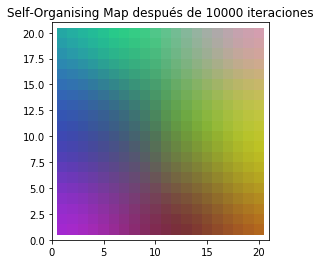

In [38]:
pintar_mapa(m_pesos)

## SOM Clasificación

### Clasifica los patrones de entrenamiento con la matriz de pesos recién entrenada

#### Definimos e inicializamos las tres matrices
##### Mapa de Clasificación: mClasificacion 
Es una matriz con las mismas dimensiones que m_pesos y guarda en cada neurona el último patron clasificado
##### Mapa de Activación: mActivacion
Es una matriz bidimensional que guarda el número de patrones reconocido por  cada neurona
##### Mapa de Distancias: mDistancias
Es una matriz bidimensional que guarda las neuronas con activación>0

In [39]:
mClasificacion = np.zeros((lado_mapa, lado_mapa, valores_color))                          
mActivacion = np.zeros((lado_mapa, lado_mapa))
mDistancias = np.zeros((lado_mapa, lado_mapa))
distanciaEuclidea = 0

#### Recorremos todo el dataset de entrenamiento

##### Imprimimos las coordenadas x e y de la BMU para cada patrón de prueba

In [40]:
for i in range (0, num_colores):
    bmu, bmu_idx = calcular_bmu(datosN[i], m_pesos, num_entradas)
    #actualizamos el mapa de clasificación, añadiendo el patrón en la neurona que lo ha reconocido
    mClasificacion[bmu_idx[0], bmu_idx[1]] = datosN[i]
    #actualizamos el mapa de activación, +1 en las activaciones
    mActivacion[bmu_idx[0], bmu_idx[1]] =+ 1
    distanciaEuclidea = np.sqrt(np.sum((bmu - datosN[i])**2)) #calculamos la distancia euclidea
    mDistancias[bmu_idx[0], bmu_idx[1]] =+ distanciaEuclidea
    print('Coordenadas BMU:', datosN[i])
    print('X = ', bmu_idx[0])
    print('Y = ', bmu_idx[1])   
    

Coordenadas BMU: [0.37301587 0.66269841 0.51984127]
X =  10
Y =  16
Coordenadas BMU: [0.24206349 0.37698413 0.67460317]
X =  1
Y =  12
Coordenadas BMU: [0.43650794 0.05555556 0.62301587]
X =  4
Y =  3
Coordenadas BMU: [0.60714286 0.02777778 0.96031746]
X =  0
Y =  0
Coordenadas BMU: [0.11111111 0.72222222 0.65873016]
X =  2
Y =  19
Coordenadas BMU: [0.60714286 0.6547619  0.66666667]
X =  14
Y =  19
Coordenadas BMU: [0.22222222 0.3531746  0.37301587]
X =  7
Y =  9
Coordenadas BMU: [0.6984127  0.64285714 0.67460317]
X =  15
Y =  19
Coordenadas BMU: [0.49206349 0.0952381  0.75396825]
X =  1
Y =  3
Coordenadas BMU: [0.17460317 0.93253968 0.62301587]
X =  5
Y =  19
Coordenadas BMU: [0.28968254 0.93650794 0.16269841]
X =  12
Y =  11
Coordenadas BMU: [0.79761905 0.4484127  0.61904762]
X =  19
Y =  19
Coordenadas BMU: [0.59126984 0.58730159 0.28968254]
X =  14
Y =  7
Coordenadas BMU: [0.43253968 0.32142857 0.57142857]
X =  5
Y =  5
Coordenadas BMU: [0.59920635 0.71031746 0.48412698]
X =  14
Y 

##### Calculamos los mapas de clasificación, activación, y distancias

Mapa de Clasificación


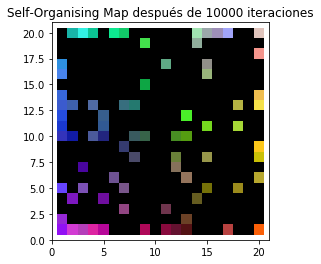


Mapa de Activación
[[1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [41]:
print('Mapa de Clasificación')
pintar_mapa(mClasificacion)
print('\nMapa de Activación')
print(mActivacion)
print('\nMapa de Distancias')
print(mDistancias)

##### Calculamos el número de clases

In [42]:
num_clases = np.count_nonzero(mActivacion)
print('Número de clases: ', num_clases)

Número de clases:  77


##### Calculamos el Error de Cuantificación y el Error Topológico del mapa

In [43]:
#error de cuantificación
eCuantificacion = (np.sum(mDistancias))/(np.sum(mActivacion))
print('Error de Cuantificación: ', eCuantificacion)


Error de Cuantificación:  0.14471503177148792


In [46]:
#error topológico
def calculate_topographical_error(patron_entrada, m_pesos, num_entradas):
    x = bmu_idx[0]
    y = bmu_idx[1]
    for a in [x-1,x,x+1]:
        for b in [y-1,y,y+1]:
    bmu = np.argsort(som.get_surface_state(), axis=1)[:,:2]

    neighbors=list(map(lambda t:variacion_vecindario(vecindario_inicial, i, periodo), bmu[:,0]))

    e_t=1-np.mean([second in neighs for (second,neighs) in zip(bmu[:,1], neighbors)])
    return(eTopologico)


print('Error de Cuantificación: ', eTopologico)

IndentationError: expected an indented block (<ipython-input-46-d5552abf4f6a>, line 7)

## SOM Prueba

In [ ]:
# Clasifica nuevos patrones

